In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the train and test datasets
train_data = pd.read_csv('../data/p_train.csv', low_memory=False)
test_data = pd.read_csv('../data/p_test.csv', low_memory=False)

# Add a marker column to differentiate train and test datasets after merging
train_data['is_train'] = 1
test_data['is_train'] = 0

# Merge the two datasets for preprocessing
combined_data = pd.concat([train_data, test_data], axis=0)

# Fill missing Sales and Customers
combined_data.loc[combined_data['Open'] == 0, ['Sales', 'Customers']] = 0
combined_data['Sales'] = combined_data.groupby('Store')['Sales'].transform('median').combine_first(combined_data['Sales'])
combined_data['Customers'] = combined_data.groupby('Store')['Customers'].transform('median').combine_first(combined_data['Customers'])

# Fill other missing values
combined_data['CompetitionDistance'] = combined_data['CompetitionDistance'].fillna(combined_data['CompetitionDistance'].max() * 1.2)
combined_data['CompetitionOpenSinceMonth'] = combined_data['CompetitionOpenSinceMonth'].fillna(0)
combined_data['CompetitionOpenSinceYear'] = combined_data['CompetitionOpenSinceYear'].fillna(0)
combined_data['Promo2SinceWeek'] = combined_data['Promo2SinceWeek'].fillna(0)
combined_data['Promo2SinceYear'] = combined_data['Promo2SinceYear'].fillna(0)
combined_data['PromoInterval'] = combined_data['PromoInterval'].fillna('None')

# Feature extraction from Date column
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data['year'] = combined_data['Date'].dt.year
combined_data['month'] = combined_data['Date'].dt.month
combined_data['day'] = combined_data['Date'].dt.day
combined_data['weekday'] = combined_data['Date'].dt.weekday

# Handle missing 'Id' if necessary
combined_data['Id'] = combined_data['Id'].fillna(-1)

# Check for missing values
print("Missing Values in Combined Data:")
print(combined_data.isna().sum())

# One-hot encode categorical variables
X = combined_data[['Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'year', 'month', 'day', 'weekday']]
X_encoded = pd.get_dummies(X, drop_first=True)
y = combined_data['Sales']

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Missing Values in Combined Data:
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
year                         0
month                        0
day                          0
weekday                      0
is_train                     0
Id                           0
dtype: int64


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Train a Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# Predictions and evaluation for Linear Regression
y_pred_lr = model_lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Squared Error: {mse_lr}, R-squared: {r2_lr}")

Linear Regression - Mean Squared Error: 887226.5730733819, R-squared: 0.8195599550574862


In [10]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model_lr, '../models/LinearRegression_model.pkl')

['../models/LinearRegression_model.pkl']

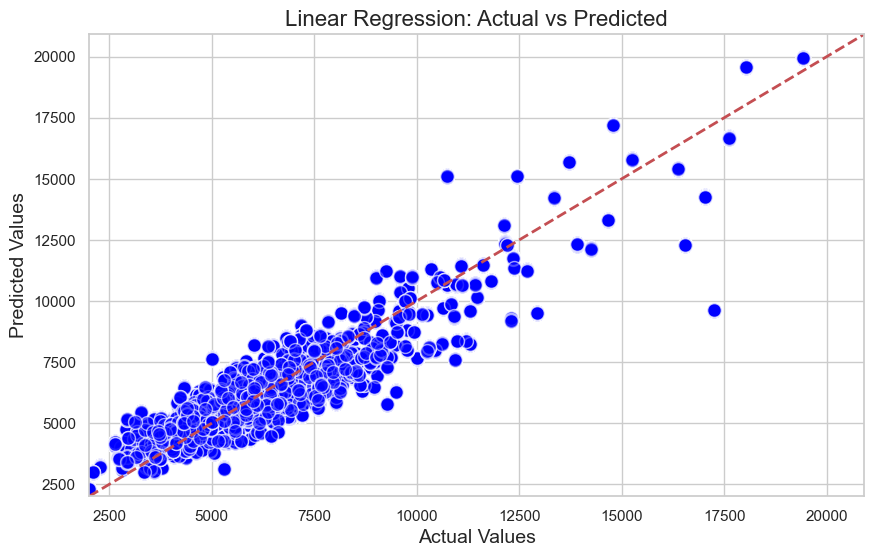

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Scatter plot for predictions vs actual values (Linear Regression)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6, edgecolors='w', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Linear Regression: Actual vs Predicted', fontsize=16)
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid(True)
plt.show()


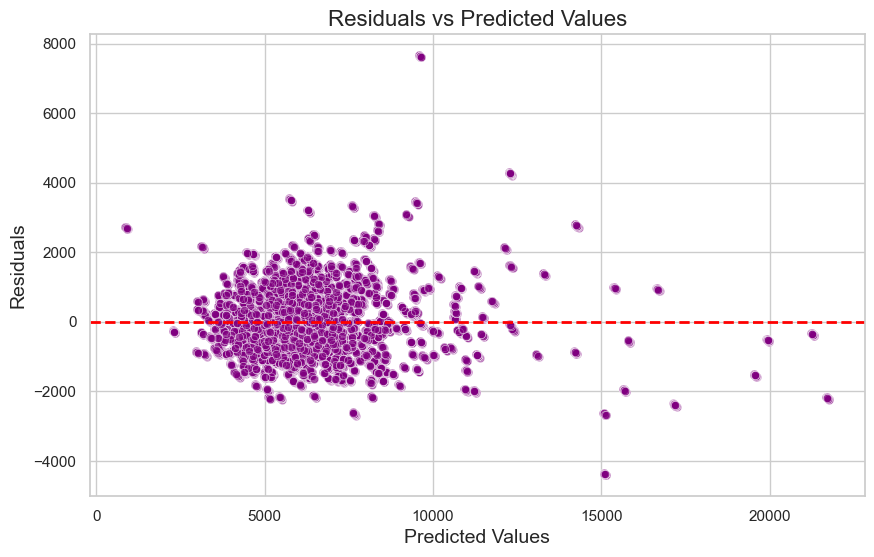

In [5]:
# Residuals plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_lr
sns.scatterplot(x=y_pred_lr, y=residuals, color='purple', alpha=0.6)
plt.axhline(0, linestyle='--', color='red', linewidth=2)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Predicted Values', fontsize=16)
plt.grid(True)
plt.show()


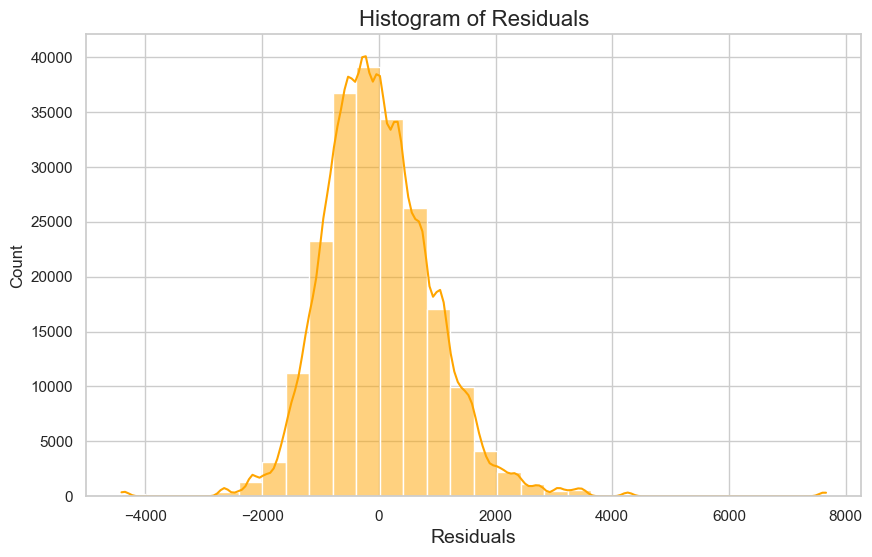

In [6]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.xlabel('Residuals', fontsize=14)
plt.title('Histogram of Residuals', fontsize=16)
plt.grid(True)
plt.show()


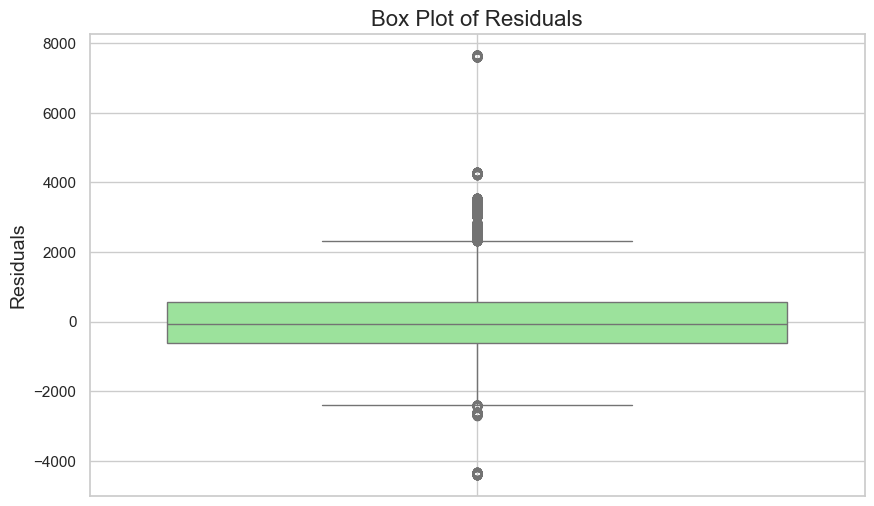

In [7]:
# Box plot of residuals
plt.figure(figsize=(10, 6))
sns.boxplot(y=residuals, color='lightgreen')
plt.ylabel('Residuals', fontsize=14)
plt.title('Box Plot of Residuals', fontsize=16)
plt.grid(True)
plt.show()
